In [1]:
import sys
sys.path.append('/home/swang597/Documents/Research/Project_heightmap/Utility_projHM')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os
import numpy as np
import tqdm
import torchvision
from torchvision import datasets, models, transforms
import copy

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

from datetime import date
# from model_3e3d import UNet_3e3d_Img, UNet_3e3d_Vec, UNet_CNN3e3d_2I_1V, UNet_CNN3e3d_2I_1V_lin2
import model_3e3d as mymodel
import glob

torch.manual_seed(1)
np.random.seed(1)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device is {device}")

nDT = 5
inI_NN1_ts_train, inI_NN1_ts_test, outV_NN1_ts_train, outV_NN1_ts_test = {}, {}, {}, {}
inI_NN2_ts_train, inI_NN2_ts_test, inV_NN2_ts_train, inV_NN2_ts_test, outI_NN2_ts_train, outI_NN2_ts_test = {},{},{},{},{},{}

# read training dataset ----------
#  Dataset for Cylinder wheel free fall
# foldername_dataPT = f"/home/swang597/Documents/Research/chrono_fork_radu/project_TireTestRig/build/DEMO_OUTPUT_freeFall/Dataset_4_ML_test_1traj_initX-6.0_initH-1.0/"
# foldername_dataPT_nm = f"/home/swang597/Documents/Research/chrono_fork_radu/project_TireTestRig/build/DEMO_OUTPUT_freeFall/Dataset_4_ML_train/"

# Dataset for Cylinder-SingleWheelTest move forward
foldername_dataPT = f"/home/swang597/Documents/Research/chrono_fork_radu/project_TireTestRig/build/DEMO_OUTPUT/Dataset_4_ML_test_diffLoad_231119/"
foldername_dataPT_nm = f"/home/swang597/Documents/Research/chrono_fork_radu/project_TireTestRig/build/DEMO_OUTPUT/Dataset_4_ML_train_diffLoad_231119/"
inI_NN1_ts_test = torch.load(foldername_dataPT +'Iin_NN1_ts_test.pt')
outV_NN1_ts_test  = torch.load(foldername_dataPT +'F_NN1_ts_test.pt')

inI_NN2_ts_test  = torch.load(foldername_dataPT +'Iin_NN2_ts_test.pt')
inV_NN2_ts_test  = torch.load(foldername_dataPT +'Vec_NN2_ts_test.pt')
outI_NN2_ts_test  = torch.load(foldername_dataPT +'Iout_NN2_ts_test.pt')

I10_NN2_ts_test = torch.load(foldername_dataPT +'I10_NN2_ts_test.pt')

# time_train = np.load(foldername_dataPT +'time_train.npy')
time_test = np.load(foldername_dataPT +'time_test.npy')
print("Read data, Done!")

device is cuda
Read data, Done!


In [28]:
Vec_min_max = np.loadtxt(foldername_dataPT_nm +'Vec_min_max.txt')  
print(Vec_min_max)                                       

[[-9.47040e-01 -2.37753e-13 -5.18689e+00 -8.39537e-14]
 [ 3.27668e-01  2.00000e+00  6.33729e-01  1.04720e+00]]


In [29]:
def eval_file_weights(filename_best_weights,NN_idx,inI, inV, outIV ):
    # print(f"inI:{inI.size()}, inV:{inV.size()}, outIV:{outIV.size()},\nfilename:{filename_best_weights}")
    directory_path = os.path.dirname(filename_best_weights)
    rand_seed = int(os.path.basename(directory_path)[8:])
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)
    print(f"rand_seed:{rand_seed}")

    # load model
    nsample_test = inV.size()[0]
    input_vec_colsize = inV.size()[-1]
    output_vec_colsize = outIV.size()[-1]
    img_channel = inI.size()[1]
    # img_channel_NN2 = inI.size()[1]

    img_rowsize, img_colsize = inI.size()[-2],inI.size()[-1]
    
    padding = 2
    poolSize1 = 2
    poolSize2 = 3
    Ksize = [3,3,3,3]
    if NN_idx == 1:
        Ksize = 5
        model = mymodel.UNet_CNN3e3d_IV_V(img_channel, img_rowsize, img_colsize, input_vec_colsize, Ksize, padding, poolSize1, poolSize2, output_vec_colsize)
        NN_keyword = 'vec'
    else:
        if len(Ksize) == 2:
            # model = mymodel.UNet_CNN3e3d_IV_I(img_channel, img_rowsize, img_colsize, input_vec_colsize, Ksize, padding, poolSize1, poolSize2)
            model = mymodel.UNet_CNN2e2d_varKsize_IV_I(img_channel, img_rowsize, img_colsize, input_vec_colsize, Ksize, poolSize1, poolSize2)
        elif len(Ksize) == 3:
            model = mymodel.UNet_CNN3e3d_varKsize_IV_I(img_channel, img_rowsize, img_colsize, input_vec_colsize, Ksize, poolSize1, poolSize2)
        elif len(Ksize) == 4:
            model = mymodel.UNet_CNN4e4d_varKsize_IV_I(img_channel, img_rowsize, img_colsize, input_vec_colsize, Ksize, poolSize1, poolSize2)
        NN_keyword = 'img'

    model.load_state_dict(torch.load(filename_best_weights))

    model.eval()

    sum_mse_test = 0.0
    Y_pred = []
    nbatch_test = 128

    with torch.no_grad():        
        for start in range(0,nsample_test,nbatch_test):
            if NN_idx == 2:
                [pred_test] = model(inI[start:start+nbatch_test], inV[start:start+nbatch_test])
                squared_error = (pred_test - outIV[start:start+nbatch_test]) ** 2
                sum_mse_test += squared_error.sum().item()/(img_rowsize*img_colsize)
                
            else:
                [pred_test] = model(inI[start:start+nbatch_test], inV[start:start+nbatch_test])
                squared_error = (pred_test - outIV[start:start+nbatch_test]) ** 2
                sum_mse_test += squared_error.sum().item()/output_vec_colsize
                
            Y_pred.extend(pred_test.cpu().numpy())

    
    loss_test = sum_mse_test/inI.size()[0]
    return (loss_test, Y_pred)

In [30]:
# Image model
NN_idx = 2
NN_keyword = 'img'

nsample_test = inV_NN2_ts_test[0].size()[0]
input_vec_colsize = inV_NN2_ts_test[0].size()[-1]
output_vec_colsize = outV_NN1_ts_test[0].size()[-1]

if NN_idx == 2:
    # folder_model = f"Model/Model_2stepNN_iDT1_img84by60_231113/" # model for cylinder-singleWheelTest free fall
    # folder_model = f"Model/Model_2stepNN_iDT1_img84by60_231117_flag_usePredI1/" # model for cylinder-singleWheelTest move forward
    # folder_model = f"Model/Model_2stepNN_iDT1_img84by60_231117_varKsize33/" # model for cylinder-singleWheelTest move forward
    # folder_model = f"Model/Model_2stepNN_iDT1_img84by60_231119_varKsize533/" # model for cylinder-singleWheelTest move forward
    folder_model = f"Model/Model_2stepNN_iDT1_img84by60_varKsize3333_231120/" # model for cylinder-singleWheelTest move forward

else:
    folder_model = f"XX"

filenames_list = glob.glob(folder_model + NN_keyword + "*/state_*.pth", recursive=True)


sorted_filenames = sorted(filenames_list, key=lambda x: x[-14:-4])
print(f"There are {len(filenames_list)} files:")
print("\n".join(sorted_filenames))

num_filename = len(filenames_list)
pth_idx, best_mse = 0, np.inf
for ifile in range(min(10,num_filename)):
    filename_best_weights = sorted_filenames[ifile]
    # print("Using file:",filename_best_weights, filename_best_weights[-14:-4])
    (loss_test, Y_pred) = eval_file_weights(filename_best_weights,NN_idx, inI_NN2_ts_test, inV_NN2_ts_test, outI_NN2_ts_test)
    
    print(f"{ifile} file:{filename_best_weights}, loss_test:{loss_test:.6f}")
    if loss_test < best_mse:
        pth_idx = ifile
        best_mse = loss_test
    # assert np.abs((loss_test - best_mse)/best_mse) < 0.5
print(f"The best file is the {pth_idx} file: loss_test:{best_mse}")

filename_best_weights_img = sorted_filenames[pth_idx]
(loss_test_img, Y_pred_img) = eval_file_weights(filename_best_weights_img,NN_idx, inI_NN2_ts_test , inV_NN2_ts_test, outI_NN2_ts_test)
Y_pred_img_np = np.array(Y_pred_img) 
print(f"Using the best file is the {pth_idx} file: loss_test:{loss_test_img}\nfilename:{filename_best_weights_img}")



There are 40 files:
Model/Model_2stepNN_iDT1_img84by60_varKsize3333_231120/img_seed11591/state_dict_epoch1438_best_mse0.00060515.pth
Model/Model_2stepNN_iDT1_img84by60_varKsize3333_231120/img_seed10637/state_dict_epoch823_best_mse0.00067122.pth
Model/Model_2stepNN_iDT1_img84by60_varKsize3333_231120/img_seed27157/state_dict_epoch80_best_mse0.00068973.pth
Model/Model_2stepNN_iDT1_img84by60_varKsize3333_231120/img_seed23791/state_dict_epoch448_best_mse0.00069949.pth
Model/Model_2stepNN_iDT1_img84by60_varKsize3333_231120/img_seed9690/state_dict_epoch312_best_mse0.00076890.pth
Model/Model_2stepNN_iDT1_img84by60_varKsize3333_231120/img_seed12600/state_dict_epoch1179_best_mse0.00077905.pth
Model/Model_2stepNN_iDT1_img84by60_varKsize3333_231120/img_seed26990/state_dict_epoch638_best_mse0.00080486.pth
Model/Model_2stepNN_iDT1_img84by60_varKsize3333_231120/img_seed1605/state_dict_epoch585_best_mse0.00085892.pth
Model/Model_2stepNN_iDT1_img84by60_varKsize3333_231120/img_seed20103/state_dict_epoch

0 file:Model/Model_2stepNN_iDT1_img84by60_varKsize3333_231120/img_seed11591/state_dict_epoch1438_best_mse0.00060515.pth, loss_test:0.000623
rand_seed:10637
1 file:Model/Model_2stepNN_iDT1_img84by60_varKsize3333_231120/img_seed10637/state_dict_epoch823_best_mse0.00067122.pth, loss_test:0.000682
rand_seed:27157
2 file:Model/Model_2stepNN_iDT1_img84by60_varKsize3333_231120/img_seed27157/state_dict_epoch80_best_mse0.00068973.pth, loss_test:0.001104
rand_seed:23791
3 file:Model/Model_2stepNN_iDT1_img84by60_varKsize3333_231120/img_seed23791/state_dict_epoch448_best_mse0.00069949.pth, loss_test:0.000736
rand_seed:9690
4 file:Model/Model_2stepNN_iDT1_img84by60_varKsize3333_231120/img_seed9690/state_dict_epoch312_best_mse0.00076890.pth, loss_test:0.004957
rand_seed:12600
5 file:Model/Model_2stepNN_iDT1_img84by60_varKsize3333_231120/img_seed12600/state_dict_epoch1179_best_mse0.00077905.pth, loss_test:0.000819
rand_seed:26990
6 file:Model/Model_2stepNN_iDT1_img84by60_varKsize3333_231120/img_seed2

Check the img results

In [31]:
(loss_test_img, Y_pred_img) = eval_file_weights(filename_best_weights_img,2, inI_NN2_ts_test, inV_NN2_ts_test, outI_NN2_ts_test)
Y_pred_img_np = np.array(Y_pred_img) 

rand_seed:11591


In [32]:
Y_pred_img_ts = torch.from_numpy(Y_pred_img_np)
mse = F.mse_loss(Y_pred_img_ts, outI_NN2_ts_test, reduction='none')
mse_per_image = mse.mean(dim=[1, 2, 3])  # Average over channels, height, and width

# Find the indices of the images with the top 5 maximum errors
top_errors, top_error_indices = torch.topk(mse_per_image, 50)

# If you need the actual error values
max_error_values = mse_per_image[top_error_indices]
print(max_error_values)

top_error_indices = top_error_indices[::10]
print(top_error_indices)

tensor([0.0120, 0.0117, 0.0100, 0.0089, 0.0061, 0.0055, 0.0043, 0.0040, 0.0038,
        0.0036, 0.0034, 0.0033, 0.0033, 0.0033, 0.0032, 0.0031, 0.0030, 0.0029,
        0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0026, 0.0026, 0.0026, 0.0026,
        0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
        0.0025, 0.0024, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0023, 0.0023,
        0.0023, 0.0023, 0.0023, 0.0023, 0.0022])
tensor([634, 665, 377, 763, 841])


[[-9.47040e-01 -2.37753e-13 -5.18689e+00 -8.39537e-14]
 [ 3.27668e-01  2.00000e+00  6.33729e-01  1.04720e+00]]


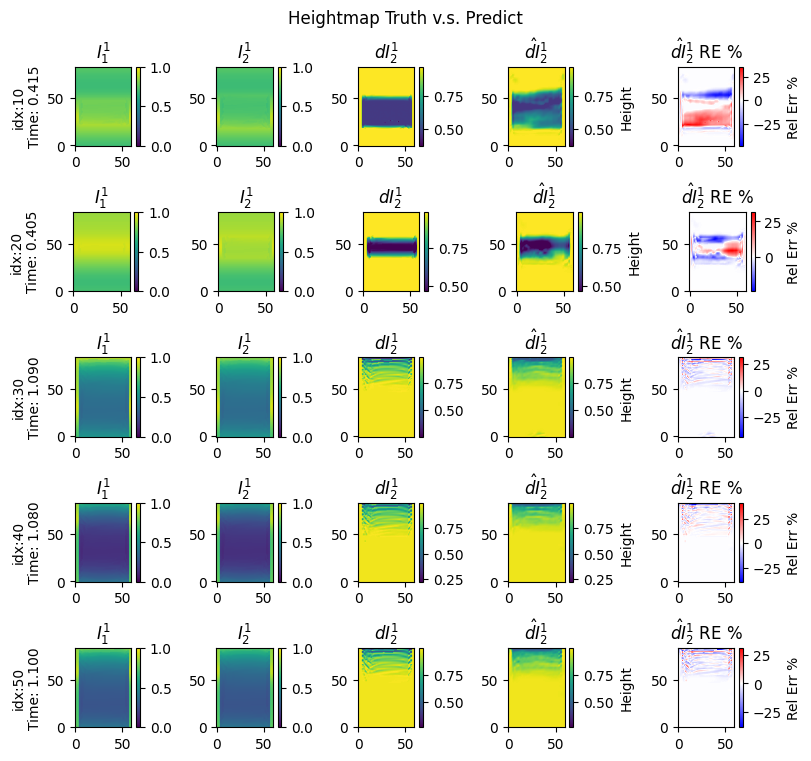

In [33]:
print(Vec_min_max)
Zmin, Zmax = Vec_min_max[0,0], Vec_min_max[1,0]
Vzmin, Vzmax = Vec_min_max[0,1], Vec_min_max[1,1]

# plot img predict results
rows =len(top_error_indices)
columns = 5

fig = plt.figure(constrained_layout=True,figsize=(8,1.5*rows))
fig.suptitle('Heightmap Truth v.s. Predict')

# sorted_indices = np.argsort(time_test)
# selected_elements = np.sort(random.sample(range(len(sorted_indices)), 5))
# create 3x1 subfigs
subfigs = fig.subfigures(nrows=rows, ncols=1)
for row, subfig in enumerate(subfigs):
    axs = subfig.subplots(nrows=1, ncols=columns)
    # idx_plot = sorted_indices[row*80+100] #sorted_indices[int(row*len(sorted_indices)/rows)]
    idx_plot = top_error_indices[row]
    inI_test = inI_NN2_ts_test[idx_plot][0]
    outI_test = outI_NN2_ts_test[idx_plot][0]
    outI_pred = torch.from_numpy(Y_pred_img[idx_plot][0]).float()

    I21_test = I10_NN2_ts_test[idx_plot][0]

    im0 = axs[0].imshow(inI_test, cmap='viridis',origin='lower',vmin=0, vmax=1)
    subfig.colorbar(im0, ax=axs[0])#,  label='Height')
    # axs[0].set_ylabel(f"time:{time_test[idx_plot]:.3f}, idx:{idx_plot}")
    axs[0].set_ylabel(f"idx:{(row+1)*10}\nTime: {time_test[idx_plot]:.3f}")  

    im1 = axs[1].imshow(I21_test, cmap='viridis',origin='lower',vmin=0, vmax=1)
    subfig.colorbar(im1, ax=axs[1])#,  label='Height')
    # axs[1].set_ylabel(f'Z={(inV_NN2_ts_test[idx_plot][0]*(Zmax-Zmin)+Zmin):.3f}\nVz={(inV_NN2_ts_test[idx_plot][1]*(Vzmax-Vzmin)+Vzmin):.3f}')  
    

    vmin_test, vmax_test = torch.min(outI_test), torch.max(outI_test)
    im2 = axs[2].imshow(outI_test, cmap='viridis',origin='lower',vmin=vmin_test, vmax=vmax_test)
    subfig.colorbar(im2, ax=axs[2])#,  label='Height')
    # axs[2].set_ylabel(f'Znm={inV_NN2_ts_test[idx_plot][0]:.3f}\nVznm={inV_NN2_ts_test[idx_plot][1]:.3f}')  
    
    im3 = axs[3].imshow(outI_pred, cmap='viridis',origin='lower',vmin=vmin_test, vmax=vmax_test)
    subfig.colorbar(im3, ax=axs[3],  label='Height')

    RE_dI = (outI_pred-outI_test)/vmax_test*100 # relative error with respect to the max value of the truth dI
    REmin, REmax = torch.min(RE_dI), torch.max(RE_dI)
    cmap = plt.cm.seismic  # Choose a colormap
    cmap_midpoint = (0 - REmin) / (REmax - REmin)  # Find midpoint for white color
    modified_cmap = mcolors.LinearSegmentedColormap.from_list(
        'Modified Colormap', 
        [(0, 'blue'), (cmap_midpoint, 'white'), (1, 'red')]
    )
    # Normalize the color scale
    norm = mcolors.Normalize(vmin=REmin, vmax=REmax)
    im4 = axs[4].imshow(RE_dI, cmap=modified_cmap,origin='lower',norm=norm)
    subfig.colorbar(im4, ax=axs[4],  label='Rel Err %')
    
    # diffdI = outI_pred-outI_test
    # dmin, dmax = torch.min(diffdI), torch.max(diffdI)
    # cmap = plt.cm.seismic  # Choose a colormap
    # cmap_midpoint = (0 - dmin) / (dmax - dmin)  # Find midpoint for white color
    # modified_cmap = mcolors.LinearSegmentedColormap.from_list(
    #     'Modified Colormap', 
    #     [(0, 'blue'), (cmap_midpoint, 'white'), (1, 'red')]
    # )
    # # Normalize the color scale
    # norm = mcolors.Normalize(vmin=dmin, vmax=dmax)
    # im5 = axs[5].imshow(diffdI, cmap=modified_cmap, origin='lower',norm=norm)
    # subfig.colorbar(im5, ax=axs[5],  label='Height')
    
    axs[0].title.set_text(r'$I_1^1$')
    axs[1].title.set_text(r'$I_2^1$')
    axs[2].title.set_text(r'$dI_2^1$') #+', Time:%.3f'%(time_output_test[idx_plot]))
    axs[3].title.set_text(r'$\hat{dI}_2^1$') #+', Time:%.3f'%(time_output_test[idx_plot]))
    axs[4].title.set_text( r'$\hat{dI}_2^1$ RE %') #+', Time:%.3f'%(time_output_test[idx_plot]))
    
    # axs[0].set_ylabel(f"DT={time_NN2_test[idx_plot]-time_NN2_test[idx_plot]:.3f}")
    
    
# fig.savefig(folder_model+'best_epoch_%d_HM.png' % (best_epoch))


In [34]:
    # im4 = axs[4].imshow((outI_pred-outI_test)/outI_test*100, cmap='viridis',origin='lower',vmin=vmin_test, vmax=vmax_test)
print(outI_pred)
print(outI_test)

tensor([[0.9884, 0.9855, 0.9790,  ..., 0.9790, 0.9929, 0.9835],
        [0.9806, 0.9875, 0.9819,  ..., 0.9819, 0.9788, 0.9805],
        [0.9783, 0.9845, 0.9789,  ..., 0.9789, 0.9796, 0.9798],
        ...,
        [1.0114, 0.8777, 0.8792,  ..., 0.9888, 1.0727, 0.9673],
        [1.1008, 0.9955, 0.8942,  ..., 0.9558, 1.0292, 0.9897],
        [1.0560, 0.9726, 0.9404,  ..., 0.9731, 1.0312, 1.0095]])
tensor([[0.9803, 0.9803, 0.9803,  ..., 0.9803, 0.9803, 0.9803],
        [0.9803, 0.9803, 0.9803,  ..., 0.9803, 0.9803, 0.9803],
        [0.9803, 0.9803, 0.9803,  ..., 0.9803, 0.9803, 0.9803],
        ...,
        [0.9803, 0.9803, 0.9803,  ..., 0.9803, 0.9803, 0.9803],
        [0.9803, 0.9803, 0.9803,  ..., 0.9803, 0.9803, 0.9803],
        [0.9803, 0.9803, 0.9803,  ..., 0.9803, 0.9803, 0.9803]])


In [35]:
print(inV_NN2_ts_test[idx_plot][0], Vec_min_max[0,0],Vec_min_max[0,1])

tensor(0.0614) -0.9470400000000001 -2.37753e-13


Check F result

In [36]:
from MyDataset import MyDataset, MyDataset_4wheel, read_multiple_dataset

NN_idx = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device is {device}")
# read dataset ----------
fn_dataset_train = f"/home/swang597/Documents/Research/chrono_fork_radu/project_TireTestRig/build/DEMO_OUTPUT/Dataset_4_ML_train/"
fn_dataset_test = f"/home/swang597/Documents/Research/chrono_fork_radu/project_TireTestRig/build/DEMO_OUTPUT/Dataset_4_ML_test_1traj_initX-6.0_initH-1.0/"
time_test = np.load(fn_dataset_test + 'time_test.npy')
state_dict_modelImg = "Model/Model_2stepNN_iDT1_img84by60_231113/img_seed12073/state_dict_epoch973_best_mse0.00075724.pth"

dataset_NN1_train = MyDataset(fn_dataset_train + 'Iin_NN1_ts_train.pt', fn_dataset_train + 'Vec_NN2_ts_train.pt', fn_dataset_train + 'F_NN1_ts_train.pt')
dataset_NN1_test = MyDataset(fn_dataset_test + 'Iin_NN1_ts_test.pt', fn_dataset_test + 'Vec_NN2_ts_test.pt', fn_dataset_test + 'F_NN1_ts_test.pt')

dataset_NN2_train = MyDataset(fn_dataset_train + 'Iin_NN2_ts_train.pt', fn_dataset_train + 'Vec_NN2_ts_train.pt', fn_dataset_train + 'Iout_NN2_ts_train.pt')
dataset_NN2_test = MyDataset(fn_dataset_test + 'Iin_NN2_ts_test.pt', fn_dataset_test + 'Vec_NN2_ts_test.pt', fn_dataset_test + 'Iout_NN2_ts_test.pt')

img_channel_NN1, img_rowsize, img_colsize = dataset_NN1_train[0][0].size()
vec_nfeature_in = dataset_NN1_train[0][1].size()[-1]
vec_nfeature_out = dataset_NN1_train[0][2].size()[-1]
img_channel_NN2 = dataset_NN2_train[0][0].size()[0]    
print(img_channel_NN1, img_rowsize, img_colsize, img_channel_NN2,vec_nfeature_in,vec_nfeature_out )

inI_NN1_ts_test = torch.load(fn_dataset_test +'Iin_NN1_ts_test.pt')
outV_NN1_ts_test  = torch.load(fn_dataset_test +'F_NN1_ts_test.pt')

inI_NN2_ts_test  = torch.load(fn_dataset_test +'Iin_NN2_ts_test.pt')
inV_NN2_ts_test  = torch.load(fn_dataset_test +'Vec_NN2_ts_test.pt')
outI_NN2_ts_test  = torch.load(fn_dataset_test +'Iout_NN2_ts_test.pt')

I10_NN2_ts_test = torch.load(fn_dataset_test +'I10_NN2_ts_test.pt')

time_test = np.load(fn_dataset_test +'time_test.npy')


device is cuda


FileNotFoundError: [Errno 2] No such file or directory: '/home/swang597/Documents/Research/chrono_fork_radu/project_TireTestRig/build/DEMO_OUTPUT/Dataset_4_ML_test_1traj_initX-6.0_initH-1.0/time_test.npy'

In [ ]:
batch_size = 128
Ksize = 5
padding = 2
poolSize1 = 2
poolSize2 = 3
flag_usePredI = 1
if NN_idx == 1:
    if flag_usePredI:
        model_Img = mymodel.UNet_CNN3e3d_IV_I(img_channel_NN2, img_rowsize, img_colsize, vec_nfeature_in, Ksize, padding, poolSize1, poolSize2)
        model_Img.load_state_dict(torch.load(state_dict_modelImg))
        print(f"*** ***Using predicted dImg model:{state_dict_modelImg}")
        device_model_Img = next(model_Img.parameters()).device
        if device_model_Img.type != device:
            model_Img = model_Img.to(device)

    model = mymodel.UNet_CNN3e3d_IV_V(img_channel_NN1, img_rowsize, img_colsize, vec_nfeature_in, Ksize, padding, poolSize1, poolSize2, vec_nfeature_out)
    NN_keyword = 'vec'
    train_loader = DataLoader(dataset=dataset_NN1_train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=dataset_NN1_test, batch_size=batch_size, shuffle=True)
else:
    model = mymodel.UNet_CNN3e3d_IV_I(img_channel_NN2, img_rowsize, img_colsize, vec_nfeature_in, Ksize, padding, poolSize1, poolSize2)
    NN_keyword = 'img'
    train_loader = DataLoader(dataset=dataset_NN2_train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=dataset_NN2_test, batch_size=batch_size, shuffle=True)

device_model = next(model.parameters()).device
if device_model.type != device:
    model = model.to(device)


*** ***Using predicted dImg model:Model/Model_2stepNN_iDT1_img84by60_231113/img_seed12073/state_dict_epoch973_best_mse0.00075724.pth


In [ ]:
def eval_file_weights_usePredImg(filename_best_weights_vec, model, model_Img, test_loader ):
    # print(f"inI:{inI.size()}, inV:{inV.size()}, outIV:{outIV.size()},\nfilename:{filename_best_weights}")
    directory_path = os.path.dirname(filename_best_weights_vec)
    rand_seed = int(os.path.basename(directory_path)[8:])
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)
    print(f"rand_seed:{rand_seed}")

    model.load_state_dict(torch.load(filename_best_weights_vec))

    model.eval()

    sum_mse_test, sum_num_test = 0.0, 0
    outputs_pred_all = []
    with torch.no_grad():
        for input_Img, input_Vec, outputs in test_loader:
            input_Img_dI = model_Img(input_Img[:,0,:,:].unsqueeze(1), input_Vec)
            input_Img_dI = torch.cat(input_Img_dI, 0)
            Input_Img_new = torch.cat([input_Img[:,0,:,:].unsqueeze(1), input_Img_dI], dim=1)
            input_Img = Input_Img_new

            if not input_Img.is_cuda:
                input_Img = input_Img.to(device)
                input_Vec = input_Vec.to(device)
                outputs = outputs.to(device)
                
            [outputs_pred] = model(input_Img, input_Vec)
            # sq_err = torch.sum((outputs_pred - outputs)**2)/(outputs_pred[0].numel())
            # print("numel",outputs_pred[0].numel())
            mse_batch = nn.functional.mse_loss(outputs_pred, outputs)
            sum_mse_test += mse_batch.item()*len(outputs)
            sum_num_test += len(outputs)
            outputs_pred_all.extend(outputs_pred.cpu())
    
    loss = sum_mse_test/sum_num_test
    return [loss, outputs_pred_all]

In [ ]:
# Vector model
NN_idx = 1
NN_keyword = 'vec'
folder_model = '/home/swang597/Documents/Research/chrono_fork_radu/project_TireTestRig/Model/Model_2stepNN_iDT1_img84by60_231114_flag_usePredI1/'
filenames_list = glob.glob(folder_model + NN_keyword + "*/state_*.pth", recursive=True)
# Sort the list of filenames based on characters in positions [-14:-4]
sorted_filenames = sorted(filenames_list, key=lambda x: x[-14:-4])
print(f"There are {len(filenames_list)} files:")
print("\n".join(sorted_filenames))

num_filename = len(filenames_list)
pth_idx, best_mse = 0, np.inf
for ifile in range(num_filename):
    filename_best_weights = sorted_filenames[ifile]
    # print("Using file:",filename_best_weights, filename_best_weights[-14:-4])
    (loss_test, Y_pred) = eval_file_weights_usePredImg(filename_best_weights, model, model_Img, test_loader)

    print(f"{ifile} file:{filename_best_weights}, loss_test:{loss_test:.6f}")
    if loss_test < best_mse:
        pth_idx = ifile
        best_mse = loss_test
    # assert np.abs((loss_test - best_mse)/best_mse) < 0.5
print(f"The best file is the {pth_idx} file: loss_test:{best_mse}")
filename_best_weights_vec = sorted_filenames[pth_idx]
(loss_test_vec, Y_pred_vec) = eval_file_weights_usePredImg(filename_best_weights_vec, model, model_Img, test_loader)
Y_pred_vec_np = np.array(Y_pred_vec) 
print(f"Using the best file is the {pth_idx} file: loss_test:{loss_test_vec:.6f}\nfilename:{filename_best_weights_vec}")
    

There are 9 files:
/home/swang597/Documents/Research/chrono_fork_radu/project_TireTestRig/Model/Model_2stepNN_iDT1_img84by60_231114_flag_usePredI1/vec_seed9338/state_dict_epoch429_best_mse0.01138405.pth
/home/swang597/Documents/Research/chrono_fork_radu/project_TireTestRig/Model/Model_2stepNN_iDT1_img84by60_231114_flag_usePredI1/vec_seed19663/state_dict_epoch63_best_mse0.01141295.pth
/home/swang597/Documents/Research/chrono_fork_radu/project_TireTestRig/Model/Model_2stepNN_iDT1_img84by60_231114_flag_usePredI1/vec_seed26638/state_dict_epoch109_best_mse0.18809203.pth
/home/swang597/Documents/Research/chrono_fork_radu/project_TireTestRig/Model/Model_2stepNN_iDT1_img84by60_231114_flag_usePredI1/vec_seed7248/state_dict_epoch503_best_mse0.18809203.pth
/home/swang597/Documents/Research/chrono_fork_radu/project_TireTestRig/Model/Model_2stepNN_iDT1_img84by60_231114_flag_usePredI1/vec_seed25985/state_dict_epoch17_best_mse0.18809203.pth
/home/swang597/Documents/Research/chrono_fork_radu/project_T

In [ ]:
initX, initH = 0.0, -1.0
foldername_SCM_data = f"/home/swang597/Documents/Research/chrono_fork_radu/project_TireTestRig/build/DEMO_OUTPUT/TIRE_TEST_RIG_dt0.000500_terrGrid0.005000terrX{initX:6f}terrH{initH:.6f}/"
data_SCM_F = np.loadtxt(foldername_SCM_data + 'SCM_force_saved.txt')
data_SCM_state = np.loadtxt(foldername_SCM_data + 'ROVER_states_saved.txt')
print(time_test)

[0.23  0.235 0.24  0.245 0.25  0.255 0.26  0.265 0.27  0.275 0.28  0.285
 0.29  0.295 0.3   0.305 0.31  0.315 0.32  0.325 0.33  0.335 0.34  0.345
 0.35  0.355 0.36  0.365 0.37  0.375 0.38  0.385 0.39  0.395 0.4   0.405
 0.41  0.415 0.42  0.425 0.43  0.435 0.44  0.445 0.45  0.455 0.46  0.465
 0.47  0.475 0.48  0.485 0.49  0.495 0.5   0.505 0.51  0.515 0.52  0.525
 0.53  0.535 0.54  0.545 0.55  0.555]


[ -15.3614 8683.61  ]
(66, 1) (66, 1)
0.23 46
0.28 56
0.33 66
0.38 76
0.43 86
0.48 96
0.53 106


Text(0.5, 0.98, 'Force/Torque Truth (star) v.s. Predict (circle)')

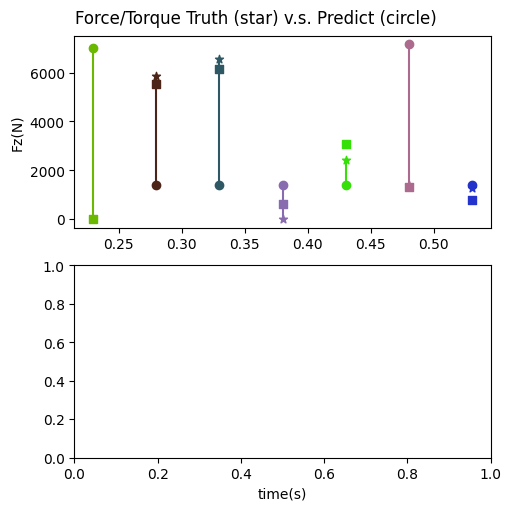

In [ ]:
# plot vec predict results Y_vec_pred_np
# dF_min_max = np.loadtxt(foldername_dataPT+'dF_min_max.txt')
F_min_max = np.loadtxt(foldername_dataPT_nm+'F_min_max.txt')
print(F_min_max)
Y_vec_pred_np_unscal = Y_pred_vec_np *(F_min_max[1] - F_min_max[0]) + F_min_max[0]
Y_vec_test_unscal = np.array(outV_NN1_ts_test) *(F_min_max[1] - F_min_max[0]) + F_min_max[0]
print(np.shape(Y_vec_pred_np_unscal), np.shape(Y_vec_test_unscal))

idx_F = [6] #[4,6,8] 
ylabel = ['Fz(N)'] #['Fx(N)','Fz(N)','Ty(N*m)']
fig, ax = plt.subplots(len(ylabel)+1, 1, constrained_layout=True,figsize=(5,5))
colors = ['red', 'blue', 'green', 'orange', 'purple']
shapes = [ 'o', '*', 's', 'D', '^']
np.random.seed(1)
for iax in range(len(ylabel)):
    iforce = iax
    for idx in range(0,len(time_test)-1,10):
        color = np.random.rand(3,)
        ax[iax].scatter(time_test[idx], data_SCM_F[int(time_test[idx+1]/0.005) ,idx_F[iforce]], color=color, marker=shapes[2])
        ax[iax].scatter(time_test[idx], Y_vec_test_unscal[idx,iforce], color=color, marker=shapes[1])
        ax[iax].scatter(time_test[idx], Y_vec_pred_np_unscal[idx,iforce], color=color, marker=shapes[0])
        print(time_test[idx],int(time_test[idx]/0.005)) #, data_SCM_F[int(time_test[idx]/0.005)])
        ax[iax].plot([time_test[idx], time_test[idx]], [Y_vec_pred_np_unscal[idx,iforce], Y_vec_test_unscal[idx,iforce]], '-',color=color)
        ax[iax].set(ylabel= ylabel[iax])
        
ax[-1].set(xlabel='time(s)')
fig.suptitle('Force/Torque Truth (star) v.s. Predict (circle)')
# ax.set_title(keyword)
# fig.savefig('Fig/'+keyword+'_XX.png')



0
1
2
-0.880137 -0.672332 -2.71683 0.0847157


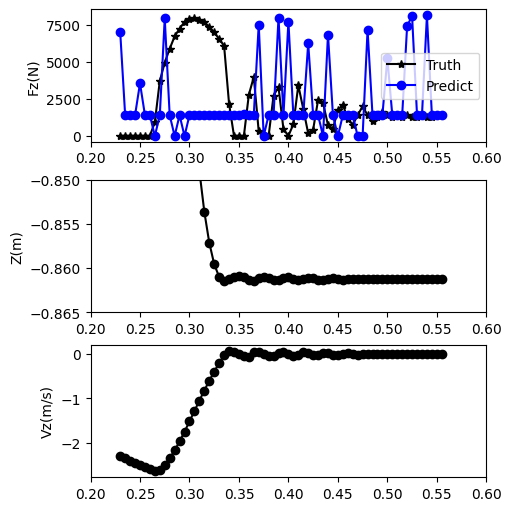

In [ ]:
# plot img predict results
inV_NN2_ts_test_np = np.array(inV_NN2_ts_test)

ylabel = ['Fz(N)','Z(m)', 'Vz(m/s)'] #['Fx(N)','Fz(N)','Ty(N*m)']
colors = ['red', 'blue', 'green', 'orange', 'purple']
shapes = [ 'o', '*', 's', 'D', '^']
np.random.seed(1)
fig, ax = plt.subplots(len(ylabel), 1, constrained_layout=True,figsize=(5,5))
for iax in range(len(ylabel)):
    print(iax)
    if iax == 0:
        # ax[iax].plot(data_SCM_F[:-1,0], data_SCM_F[1:,idx_F[iax]], color='red', marker=shapes[2])
        ax[iax].plot(time_test, Y_vec_test_unscal[:,iax], color='black', marker=shapes[1])
        ax[iax].plot(time_test, Y_vec_pred_np_unscal[:,iax], color='blue', marker=shapes[0])
    
    elif iax == 1:
        ax[iax].plot(time_test,(inV_NN2_ts_test_np[:,0]*(Zmax-Zmin)+Zmin),color='black', marker=shapes[0])
        ax[iax].set_ylim([-0.865, -0.85])
    else:
        ax[iax].plot(time_test,(inV_NN2_ts_test_np[:,1]*(Vzmax-Vzmin)+Vzmin),color='black', marker=shapes[0])
        # :.3f}\nVz={(inV_NN2_ts_test[idx_plot][1]*(Vzmax-Vzmin)+Vzmin):.3f}')  
    ax[iax].set(ylabel= ylabel[iax])
    ax[iax].set_xlim([0.2,0.6])
    ax[0].legend(['Truth','Predict'])
print(Zmin,Zmax,Vzmin,Vzmax)

In [ ]:
print(Vec_min_max)


[[-0.880137  -2.71683  ]
 [-0.672332   0.0847157]]


IndexError: index 1 is out of bounds for axis 1 with size 1

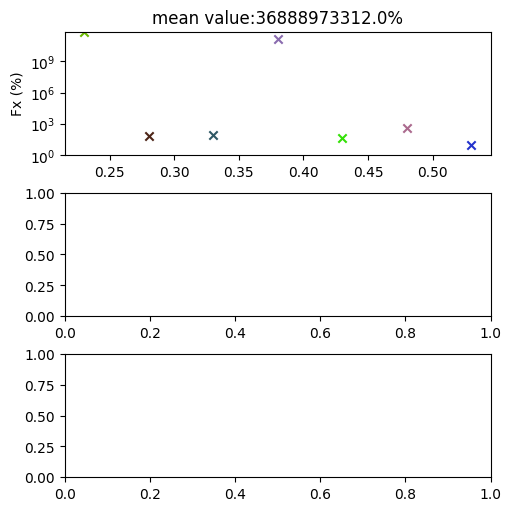

In [ ]:
# Relative err
fig, ax = plt.subplots(3, 1, constrained_layout=True,figsize=(5,5))
ylabel = ['Fx (%)','Fz (%)','Ty (%)']
colors = ['red', 'blue', 'green', 'orange', 'purple']
shapes = [ 'x', '*', 's', 'D', '^']
np.random.seed(1)
re = np.abs((Y_vec_pred_np_unscal - Y_vec_test_unscal)/Y_vec_test_unscal)*100
for iax in range(3):
    iforce = iax
    for idx in range(0,len(time_test),10):
        color = np.random.rand(3,)
        ax[iax].scatter(time_test[idx], re[idx, iforce],color=color,marker='x')
        ax[iax].set_yscale('log')
        ax[iax].set(ylabel= ylabel[iax])
    ax[iax].set_ylim([1,np.max(re,axis=0)[iax]])        
    ax[iax].set_title(f"mean value:{np.mean(re[:, iforce]):.1f}%")
ax[-1].set(xlabel='time(s)')
fig.suptitle('Relative error')
print(f"mean re is:{np.mean(re, axis=0)} %")
# ax.set_title(keyword)
# fig.savefig('Fig/'+keyword+'_XX.png')



mean re_iforce is:97.3%


IndexError: index 1 is out of bounds for axis 1 with size 1

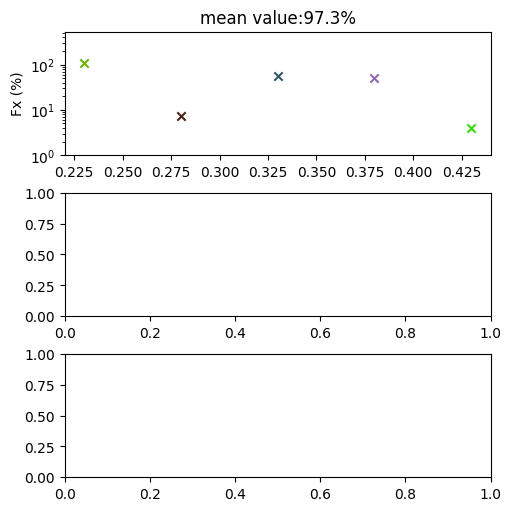

In [ ]:
# Relative err
fig, ax = plt.subplots(3, 1, constrained_layout=True,figsize=(5,5))
ylabel = ['Fx (%)','Fz (%)','Ty (%)']
colors = ['red', 'blue', 'green', 'orange', 'purple']
shapes = [ 'x', '*', 's', 'D', '^']
np.random.seed(1)
re = np.abs((Y_vec_pred_np_unscal - Y_vec_test_unscal)/Y_vec_test_unscal)*100
for iax in range(3):
    iforce = iax
    Fmax = np.max(np.abs(Y_vec_test_unscal[:,iforce]))
    re_iforce = re[np.abs(Y_vec_test_unscal[:,iforce]) >= np.abs(0.1*Fmax),iforce]
    print(f"mean re_iforce is:{np.mean(re_iforce):.1f}%")
    for idx in range(0,np.shape(re_iforce)[0],10):
        color = np.random.rand(3,)
        # if np.abs(Y_vec_test_unscal[idx,iforce]) < np.abs(0.1*Fmax):
        #     continue
        ax[iax].scatter(time_test[idx], re_iforce[idx],color=color,marker='x')
        ax[iax].set_yscale('log')
        ax[iax].set(ylabel= ylabel[iax])
    ax[iax].set_ylim([1,np.max(re_iforce)])   
    ax[iax].set_title(f"mean value:{np.mean(re_iforce):.1f}%")
ax[-1].set(xlabel='time(s)')
fig.suptitle('Relative error')

# ax.set_title(keyword)
# fig.savefig('Fig/'+keyword+'_XX.png')


